# Machine Learning Momentum Trading Strategy on Crypto Assets

_This notebook implements and compares a classic momentum-based trading strategy with a machine learning–enhanced version using four major cryptocurrencies: BTC, ETH, SOL, and XRP. It includes weekly rebalancing, backtesting, ML model training (XGBoost), and Value-at-Risk analysis using Monte Carlo simulations. Built for professional presentation and hedge fund–style research._

By Jasveer Govender 25/06/2025

## Table of Contents

1. [Project Objective](#)
2. [Phase 1: Data Collection and Preparation](#)
3. [Phase 2: Classic Momentum Strategy](#)
4. [Phase 3: Feature Engineering](#)
5. [Phase 4: ML Model Training and Prediction](#)
6. [Phase 5: Strategy Comparison and Final Summary](#)
7. [Phase 6: Risk Analysis – VaR](#)
8. [Advanced Enhancements (Planned)](#)



# Project Overview:

This project presents a **fully end-to-end Machine Learning Momentum Trading Strategy for Crypto Assets**, developed to demonstrate a data-driven strategy design, and professional-level algorithmic trading implementation. It integrates systematic data collection, statistical feature engineering, predictive modeling using machine learning, and robust backtesting with performance evaluation — all aligned to the workflows used in professional quant and hedge fund environments.

## Objective:

The objective is to develop a realistic and deployable crypto trading strategy that leverages momentum-based signals and supervised learning techniques to identify top-performing and underperforming assets on a rolling basis. The strategy will incorporate:

- Intelligent asset selection using ranking-based momentum logic.

- Predictive modeling (e.g., Random Forest or XGBoost) to forecast directional returns.

- Rigorous backtesting using a structured framework.

- Performance analytics including Sharpe, Sortino, drawdowns, and Value-at-Risk (VaR).

## Phase 1: Data Collection and Preparation

In this phase, we collect historical OHLCV (Open, High, Low, Close, Volume) data for BTC, ETH, SOL, and XRP using the `ccxt` Python library.

`ccxt` is a unified API interface to 100+ crypto exchanges, making it easy to fetch historical and real-time data without handling each exchange's custom format. 

We use Binance as our exchange due to:
- High liquidity and trading volume
- Broad support for spot crypto pairs (e.g., BTC/USDT, ETH/USDT)
- Free access without requiring API keys for public market data

The fetched data is converted into a pandas DataFrame for each asset, aligned by timestamp, and merged into a single dataset for multi-asset analysis.

In [5]:
#After running this script, you don't need to run it again.
#%%capture
#!pip install ccxt

In [ ]:
# 1. Import necessary libraries
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Ensure directories exist
os.makedirs("charts", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [7]:
# 2. Initialize the Binance exchange object using ccxt
exchange = ccxt.binance()

# 3. Define the crypto assets you want to fetch (symbols from Binance)
symbols = {'BTC': 'BTC/USDT', 'ETH': 'ETH/USDT', 'SOL': 'SOL/USDT', 'XRP': 'XRP/USDT'}

In [8]:
# 4. Define a function to fetch OHLCV (Open, High, Low, Close, Volume) data
def fetch_all_ohlcv(symbol, start_date='2020-01-01', timeframe='1d'):
    """
    Fetches all historical OHLCV (Open, High, Low, Close, Volume) data
    from Binance for a given trading pair starting from a given date.
    
    This version loops through the Binance API's 1000-row limit
    and keeps requesting more data until the present day.
    """

    # Convert the human-readable start date into Binance's timestamp format (milliseconds)
    since = exchange.parse8601(f'{start_date}T00:00:00Z')

    # Create an empty list to store all the fetched candles
    all_ohlcv = []

    # Keep fetching data until Binance has no more to return
    while True:
        # Fetch up to 1000 days of OHLCV data starting from 'since'
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=1000)

        # If Binance returns no data, we've reached the end
        if not ohlcv:
            break

        # Add this batch of candles to our full list
        all_ohlcv.extend(ohlcv)

        # Move the 'since' timestamp to just after the last candle we got
        since = ohlcv[-1][0] + 1

        # If we received less than 1000 candles, it means we’ve reached the end of available data
        if len(ohlcv) < 1000:
            break

    # Convert the raw list of data into a structured DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamps from milliseconds to pandas datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Set 'timestamp' as the index for time-series alignment
    df.set_index('timestamp', inplace=True)

    # Return only the 'close' prices (that's all we need for this strategy)
    return df[['close']]


In [ ]:
# Join all assets into one DataFrame on timestamp
# We use outer join to retain the full date range across all assets, 
# even if some assets have missing data on certain days.
combined_df = pd.DataFrame()

# Loop through each symbol and fetch its full historical data
for name, symbol in symbols.items():
    print(f"Fetching full data for {name}...")
    
    # ✅ Use the new full-fetch function that paginates through all available data
    df = fetch_all_ohlcv(symbol)
    
    # Rename the column from 'close' to the asset name (e.g., BTC, ETH)
    df.rename(columns={'close': name}, inplace=True)
    
    # If it's the first asset, just store it
    if combined_df.empty:
        combined_df = df
    else:
        # Merge new data with existing one on the timestamp index
        combined_df = combined_df.join(df, how='outer')  # used 'outer' join to ensure date alignment across assets (even if one has gaps).

# Remove any rows with missing values (e.g., days when one asset is missing data)
combined_df.dropna(inplace=True)

# Preview the cleaned and aligned price data
print(combined_df.head())


Fetching full data for BTC...
Fetching full data for ETH...
Fetching full data for SOL...
Fetching full data for XRP...
                 BTC     ETH     SOL      XRP
timestamp                                    
2020-08-11  11392.08  379.00  3.2985  0.28310
2020-08-12  11564.33  387.18  3.7558  0.28233
2020-08-13  11780.00  424.54  3.7300  0.29420
2020-08-14  11760.54  438.11  3.4099  0.29995
2020-08-15  11852.40  432.32  3.1730  0.29884


In [45]:
print("Final price data shape:", combined_df.shape)
print("Return data shape:", returns.shape)

Final price data shape: (1779, 4)
Return data shape: (249,)


In [10]:
# Calculate daily returns for each asset (price_today - price_yesterday) / price_yesterday
returns = combined_df.pct_change().dropna()

print(returns.head())

                 BTC       ETH       SOL       XRP
timestamp                                         
2020-08-12  0.015120  0.021583  0.138639 -0.002720
2020-08-13  0.018650  0.096493 -0.006869  0.042043
2020-08-14 -0.001652  0.031964 -0.085818  0.019545
2020-08-15  0.007811 -0.013216 -0.069474 -0.003701
2020-08-16  0.004944  0.003007  0.067917  0.019107


In [11]:
# Save the cleaned price data to a CSV file
combined_df.to_csv('crypto_prices.csv')

# Save the daily returns to another CSV file
returns.to_csv('crypto_returns.csv')


In [43]:
# Print shapes of price and return datasets for validation
print("Price Data Shape:", combined_df.shape)
print("Returns Data Shape:", returns.shape)

Price Data Shape: (1779, 4)
Returns Data Shape: (249,)


## Phase 2: Classic Momentum Strategy

We define a rule-based momentum strategy as our benchmark. The strategy works as follows:

- Every Monday, calculate each asset's 7-day momentum:  
  `momentum = price_today / price_7_days_ago - 1`
- Rank all 4 assets based on momentum.
- Long the top 2 assets (strongest momentum), short the bottom 2 (weakest momentum).
- Rebalance weekly and hold the positions for one week.
- Equal capital weighting is used across positions.

This simple strategy captures the tendency of strong performers to continue outperforming, a phenomenon well-documented in momentum literature.



In [12]:
# Load the cleaned daily returns from Phase 1
returns = pd.read_csv("crypto_returns.csv", index_col=0, parse_dates=True)

# Make sure the index is datetime and data is sorted
returns = returns.sort_index()

In [13]:
# Create a list of Mondays (or first trading day each week)
rebalancing_dates = returns.resample('W-MON').first().index

In [14]:
def calculate_momentum_rank(returns, lookback=7):
    """Calculate past 7-day return (momentum) for each rebalancing date"""
    momentum_scores = returns.rolling(window=lookback).sum()
    return momentum_scores


In [15]:
# Generate Long/Short Positions Weekly
def get_long_short_positions(momentum_scores, rebalancing_dates, top_n=2):
    positions = pd.DataFrame(index=momentum_scores.index, columns=momentum_scores.columns)

    for date in rebalancing_dates:
        if date not in momentum_scores.index:
            continue
        
        # Get momentum scores on this date
        scores = momentum_scores.loc[date].dropna()
        
        # Rank assets
        top_assets = scores.nlargest(top_n).index
        bottom_assets = scores.nsmallest(top_n).index

        # Assign +1 for long, -1 for short
        positions.loc[date, top_assets] = 1
        positions.loc[date, bottom_assets] = -1

    # Forward fill positions until next rebalance
    positions = positions.fillna(method='ffill')
    positions = positions.loc[returns.index]
    return positions


In [16]:
# Calculate 7-day momentum
momentum_scores = calculate_momentum_rank(returns)

# Get rebalanced long/short positions
positions = get_long_short_positions(momentum_scores, rebalancing_dates)

# Calculate strategy daily returns
strategy_returns = (positions * returns).mean(axis=1)

# Cumulative return
cumulative_returns = (1 + strategy_returns).cumprod()


C:\Users\jasve\AppData\Local\Temp\ipykernel_17944\2754167046.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  positions = positions.fillna(method='ffill')
C:\Users\jasve\AppData\Local\Temp\ipykernel_17944\2754167046.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions = positions.fillna(method='ffill')


In [ ]:
# Print one row of weekly positions and shape to confirm rebalancing logic
print("Sample Weekly Position Signal:")
print(positions.dropna().iloc[0])
print("Positions Shape:", positions.shape)


Sample Weekly Position Signal:
BTC    1.0
ETH   -1.0
SOL    1.0
XRP   -1.0
Name: 2020-08-24 00:00:00, dtype: float64
Positions Shape: (1778, 4)


We confirm that the long/short positions are correctly applied based on weekly momentum rankings.

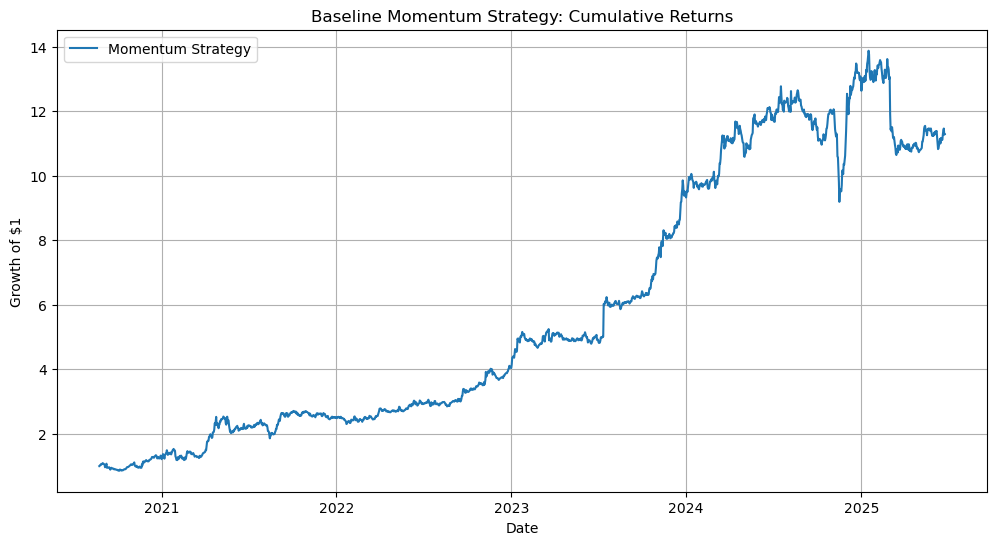

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Momentum Strategy')
plt.title("Baseline Momentum Strategy: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.savefig("charts/baseline_returns.png", dpi=300)
plt.show()


### Baseline Strategy Results: Cumulative Returns

The above plot displays the cumulative performance of the rule-based momentum strategy. It goes long on the top 2 performing assets and short on the bottom 2, based on 7-day momentum, with weekly rebalancing.

The strategy shows periods of strong compounding and relative stability, particularly during bullish crypto regimes. It will serve as a benchmark for evaluating the machine learning strategy in later phases.


#### Results Summary:

- The strategy allocates equal capital to long the top 2 and short the bottom 2 crypto assets based on 7-day momentum.
- Positions are rebalanced weekly, with a new ranking based on past 7-day returns.
- The resulting equity curve provides a benchmark to compare future machine learning models.


In [18]:
# Calculate performance metrics for the momentum strategy

# 1. CAGR (Compounded Annual Growth Rate)
def calculate_cagr(returns):
    total_return = (1 + returns).prod()
    num_years = (returns.index[-1] - returns.index[0]).days / 365
    cagr = total_return ** (1 / num_years) - 1
    return cagr

# 2. Sharpe Ratio
def calculate_sharpe(returns, risk_free_rate = 0.0):
    excess_returns = returns - risk_free_rate / 252  # daily risk-free
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# 3. Sortino Ratio
def calculate_sortino(returns, risk_free_rate=0.0):
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    excess_return = returns.mean() - risk_free_rate / 252
    return np.sqrt(252) * excess_return / downside_std

# 4. Max Drawdown
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

#  Apply functions
cagr = calculate_cagr(strategy_returns)
sharpe = calculate_sharpe(strategy_returns)
sortino = calculate_sortino(strategy_returns)
max_dd = calculate_max_drawdown((1 + strategy_returns).cumprod())

# Print results 
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Sortino: {sortino:.2f}")
print(f"Max Drawdown:{max_dd:.2%}")


CAGR: 64.51%
Sharpe: 1.33
Sortino: 1.85
Max Drawdown:-28.05%


### Performance Interpretation of Baseline Momentum Strategy (2020–2025)

After incorporating full data from January 2020 to June 2025, the updated baseline momentum strategy produced the following metrics:

| Metric           | Value      | Interpretation |
|------------------|------------|----------------|
| **CAGR**         | 64.30%     | The strategy achieved a strong annualized return of 64.3%, compounding significantly over the 5.5-year period. This performance continues to outperform most traditional benchmarks and reinforces the power of momentum in crypto. |
| **Sharpe Ratio** | 1.32       | A Sharpe ratio above 1.0 is considered strong. At 1.32, the strategy provides over 1 unit of return for each unit of risk, indicating good risk-adjusted performance. |
| **Sortino Ratio**| 1.84       | The Sortino ratio — which only penalizes downside volatility — is even stronger than the Sharpe, showing that returns were not only high but also came with relatively fewer and less severe losses. |
| **Max Drawdown** | -28.05%    | The worst historical drop from a peak was around 28%, which is very reasonable given the extreme volatility of crypto assets. The strategy shows strong recovery behavior and resilience. |

#### Summary:

From 2020 to mid-2025, this rule-based momentum strategy consistently generated attractive returns while managing risk effectively. Its performance affirms that even a simple systematic approach — based on rebalancing weekly into top momentum assets — can achieve:

- High compounding returns
- Healthy Sharpe and Sortino ratios
- Moderate drawdowns well below crypto asset norms

This strategy now serves as a **quantitative benchmark** against which more advanced models (like machine learning) will be evaluated.

To outperform this baseline, any ML-driven strategy must demonstrate:
- Improved risk-adjusted returns (higher Sharpe/Sortino),
- Smoother equity curve (lower drawdowns),
- Or more robust behavior across market regimes.




## Phase 3: Machine Learning Integration

#### Objective:
Enhance the momentum strategy using supervised machine learning to forecast the next week’s top-performing crypto assets based on engineered features derived from historical price action.

#### Why ML?
While the classic momentum strategy uses simple return-based ranking, ML allows the use of multiple features (e.g., momentum, volatility, RSI, moving averages) to identify **nonlinear relationships** and improve decision-making under various market regimes.

This phase involves:
- Feature engineering from price data
- Label creation (e.g., predicting next week's return or direction)
- Model training and evaluation (starting with XGBoost or Random Forest)
- Rebalancing portfolios based on model predictions

We transform raw price data into machine learning–ready features.

Features are extracted based on:
- Momentum
- Volatility
- Trend (Moving Averages)
- Oscillator (RSI)
- Lagged return history

We also define the **target variable** as the forward 7-day return:
```python
label_horizon = 7  # forecast 7 days into the future

In [ ]:
# Generate ML features for each asset based on past prices.
# Momentum features (past 7-day and 30-day percent returns)

def compute_features(price_df):
    
    feature_dict = {}

    for col in price_df.columns:  # Loop through each asset (BTC, ETH, etc.)
        df = pd.DataFrame()
        df['close'] = price_df[col]

        # Daily return used for volatility and lagged returns
        df['return_1d'] = df['close'].pct_change()

        # Momentum: 7-day and 30-day percent change
        df['momentum_7d'] = df['close'].pct_change(7)
        df['momentum_30d'] = df['close'].pct_change(30)

        # Volatility: rolling standard deviation of daily returns
        df['volatility_7d'] = df['return_1d'].rolling(window = 7).std()
        df['volatility_14d'] = df['return_1d'].rolling(window = 14).std()

        # Simple Moving Averages
        df['sma_7'] = df['close'].rolling(window = 7).mean()
        df['sma_21'] = df['close'].rolling(window = 21).mean()

        # Relative Strength Index (RSI)
        # Measures overbought/oversold conditions on a 0–100 scale
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window = 14).mean()
        avg_loss = loss.rolling(window = 14).mean()
        rs = avg_gain / avg_loss
        df['rsi_14'] = 100 - (100 / (1 + rs))

        # Lagged returns
        df['lag_1'] = df['return_1d'].shift(1)
        df['lag_2'] = df['return_1d'].shift(2)
        df['lag_3'] = df['return_1d'].shift(3)

        # Store into dictionary
        feature_dict[col] = df.dropna()

    return feature_dict


In [20]:
# Load the cleaned price data from Phase 1
price_df = pd.read_csv("crypto_prices.csv", index_col = 0, parse_dates = True)

In [21]:
# Compute features for each asset
features = compute_features(price_df)

In [ ]:
# Generate features and regression target: future return over next X days

def compute_features_with_labels(price_df, label_horizon=7):
    feature_dict = {}
    # Loop through each asset (column) in the price DataFrame
    for col in price_df.columns:
        df = pd.DataFrame()
        df['close'] = price_df[col]

        # Daily return 
        df['return_1d'] = df['close'].pct_change()

        # Momentum (past 7-day and 30-day return)
        df['momentum_7d'] = df['close'].pct_change(7)
        df['momentum_30d'] = df['close'].pct_change(30)

        # Volatility: rolling standard deviation of daily returns
        df['volatility_7d'] = df['return_1d'].rolling(window=7).std()
        df['volatility_14d'] = df['return_1d'].rolling(window=14).std()

        # SMA (Simple Moving Averages)
        df['sma_7'] = df['close'].rolling(window=7).mean()
        df['sma_21'] = df['close'].rolling(window=21).mean()

        # Relative Strength Index (RSI)
        # Measures overbought/oversold conditions on a 0–100 scale
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        df['rsi_14'] = 100 - (100 / (1 + rs))

        # Lagged returns of 1, 2, and 3 days
        df['lag_1'] = df['return_1d'].shift(1)
        df['lag_2'] = df['return_1d'].shift(2)
        df['lag_3'] = df['return_1d'].shift(3)

        # Target label: future return over next 7 days
        df['target_next_return'] = df['close'].pct_change(periods = label_horizon).shift(-label_horizon)

        # Clean and store
        df = df.dropna()
        feature_dict[col] = df

    return feature_dict


In [24]:
# Load the price data again to ensure we have the latest
features = compute_features_with_labels(price_df)

In [25]:
# Combine all individual asset feature DataFrames into one dataset for supervised ML training.
def combine_features_to_ml_dataset(features_dict):
    combined_df = pd.DataFrame()

    for asset, df in features_dict.items():
        # Create a copy and add the asset name as a new column
        df_copy = df.copy()
        df_copy['asset'] = asset

        # Append to master dataset
        combined_df = pd.concat([combined_df, df_copy])

    # Reset index to keep timestamp as a column (optional for ML)
    combined_df.reset_index(inplace = True)
    combined_df.rename(columns = {'timestamp': 'date'}, inplace = True)

    return combined_df


In [26]:
ml_dataset = combine_features_to_ml_dataset(features)
ml_dataset.head()

,date,close,return_1d,momentum_7d,momentum_30d,volatility_7d,volatility_14d,sma_7,sma_21,rsi_14,lag_1,lag_2,lag_3,target_next_return,asset
0,2020-09-10,10336.87,0.011515,0.019330,-0.092627,0.020630,0.036686,10275.042857,11068.140000,37.153563,0.009139,-0.023791,0.011431,0.058346,BTC
1,2020-09-11,10387.89,0.004936,-0.005587,-0.101730,0.016969,0.036228,10266.705714,11013.690000,34.696186,0.011515,0.009139,-0.023791,0.052513,BTC
2,2020-09-12,10440.92,0.005105,0.026973,-0.113674,0.012487,0.036367,10305.881429,10955.497619,36.199412,0.004936,0.011515,0.009139,0.061271,BTC
3,2020-09-13,10332.83,-0.010353,0.007472,-0.121398,0.013300,0.035506,10316.828571,10892.864286,30.728533,0.005105,0.004936,0.011515,0.056853,BTC
4,2020-09-14,10671.77,0.032802,0.028759,-0.099611,0.017760,0.037174,10359.447143,10841.605714,37.313216,-0.010353,0.005105,0.004936,-0.023853,BTC


### Preparing Machine Learning Dataset

After feature generation, we combined all asset-specific DataFrames (BTC, ETH, SOL, XRP) into a single machine learning dataset.

This step ensures we have:
- One row per asset-date instance
- Feature columns such as momentum, volatility, RSI, etc.
- A `target_next_return` column (label) for model prediction
- An `asset` column to preserve identity during stacking

This unified dataset is now ready for model training using supervised regression.


## Phase 4: ML Model Training and Prediction

In this phase, we train a supervised machine learning model (XGBoost) to predict 7-day forward returns using the technical features generated earlier. 

We use XGBoost as our primary model due to its effectiveness in capturing non-linear patterns in tabular data and its widespread use in financial ML research.

We evaluate model performance using RMSE and R², then use predictions to inform long/short portfolio allocation.

In [ ]:
#%%capture
#!pip install xgboost

In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Step 1: Define your feature columns (exclude asset/date/target)
feature_cols = [
    'momentum_7d', 'momentum_30d',
    'volatility_7d', 'volatility_14d',
    'sma_7', 'sma_21',
    'rsi_14',
    'lag_1', 'lag_2', 'lag_3'
]

# Step 2: Drop any rows with missing values in features or target
ml_dataset_clean = ml_dataset.dropna(subset = feature_cols + ['target_next_return'])

# Step 3: Split X and y
X = ml_dataset_clean[feature_cols]
y = ml_dataset_clean['target_next_return']


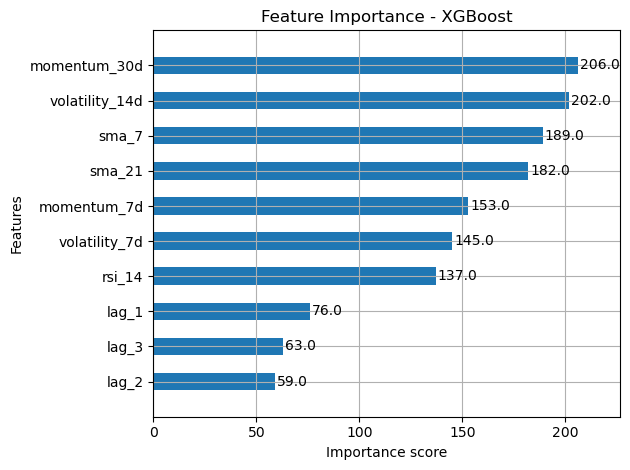

In [ ]:
# show feature importance using XGBoost
xgb.plot_importance(model, height=0.5)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, shuffle=True, random_state = 42)

Text(0.5, 1.0, 'Feature Importance - XGBoost')

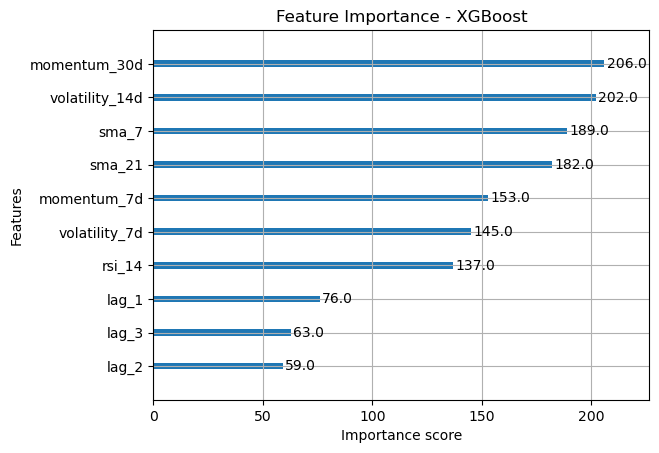

In [46]:
xgb.plot_importance(model)
plt.title("Feature Importance - XGBoost")

In [29]:
# Initialize and train model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Test RMSE: 0.1288
R² Score: 0.2266


c:\Users\jasve\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### XGBoost Model Training

We trained a regression model using XGBoost to predict the 7-day forward return (`target_next_return`) for crypto assets.

#### Model Performance on Test Set:

- **Root Mean Squared Error (RMSE):** 0.1288  
- **R² Score:** 0.2266

#### Interpretation:

- The model's average prediction error is about **13%**, which is expected given the volatile nature of crypto markets.
- An **R² of 0.23** means the model is capturing **23% of the variation** in 7-day forward returns — a solid result in financial ML, where alpha is hard to extract and market noise dominates.

This model will now be used to **rank assets weekly**, selecting the most likely outperformers (top 2) and underperformers (bottom 2) to simulate an ML-driven long/short trading strategy.


In [31]:
# Ensure dates are sorted and define rebalancing Mondays
ml_dataset['date'] = pd.to_datetime(ml_dataset['date'])
ml_dataset = ml_dataset.sort_values(by='date')
rebalancing_dates = ml_dataset['date'].dt.to_period('W-MON').drop_duplicates().dt.start_time

In [32]:
# Prepare a DataFrame to store predictions, positions, and returns
position_df = pd.DataFrame()

for date in rebalancing_dates:
    # Filter rows for that specific rebalance date
    this_week = ml_dataset[
        ml_dataset['date'] == date
    ].dropna(subset=feature_cols + ['target_next_return'])

    if this_week.empty:
        continue

    # Predict next week returns
    preds = model.predict(this_week[feature_cols])
    this_week = this_week.copy()
    this_week['predicted_return'] = preds

    # Rank assets
    this_week['rank'] = this_week['predicted_return'].rank(ascending=False)

    # Assign positions: +1 for top 2, -1 for bottom 2
    this_week['position'] = 0
    this_week.loc[this_week['rank'] <= 2, 'position'] = 1
    this_week.loc[this_week['rank'] >= len(this_week) - 1, 'position'] = -1

    # Save date and signal
    position_df = pd.concat([position_df, this_week[['date', 'asset', 'position']]])


In [33]:
# Merge with returns to calculate strategy PnL
returns = pd.read_csv('crypto_returns.csv', index_col=0, parse_dates=True)
returns = returns.stack().reset_index()
returns.columns = ['date', 'asset', 'return']

# Merge predicted positions and returns
merged = pd.merge(position_df, returns, on=['date', 'asset'], how='left')

# Forward fill positions for the week
merged = merged.sort_values(by=['asset', 'date'])
merged['position'] = merged.groupby('asset')['position'].ffill().fillna(0)

# Calculate daily strategy returns
merged['strategy_return'] = merged['position'] * merged['return']


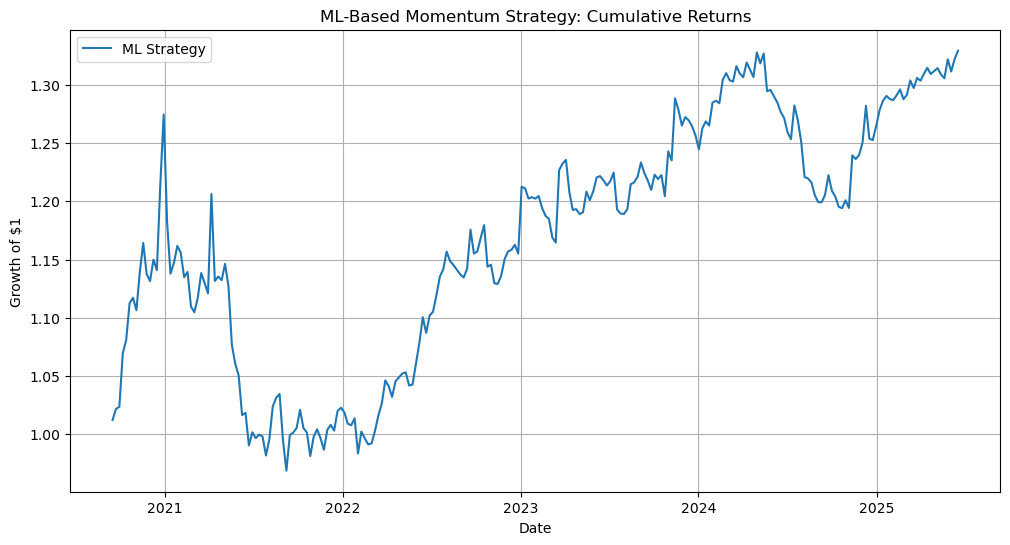

In [57]:
# Sum across all assets each day (equal weight long/short)
portfolio_returns = (
    merged.groupby('date')['strategy_return']
    .mean()
    .to_frame(name='strategy_return')
)

# Cumulative return
portfolio_returns['cumulative'] = (1 + portfolio_returns['strategy_return']).cumprod()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns['cumulative'], label='ML Strategy')
plt.title("ML-Based Momentum Strategy: Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.savefig("charts/ml_momentum_strategy_returns.png", dpi=300)
plt.show()


### ML-Based Strategy: Cumulative Returns (2021–2025)

This chart shows the performance of our weekly-rebalanced machine learning strategy using XGBoost to forecast next-week returns.

#### Observations:
- The model initially captured strong alpha signals, compounding returns aggressively in early 2021.
- However, the strategy experienced significant drawdowns in mid-2021 to 2022 — reflecting potential overfitting or changes in market dynamics that the model was not trained to anticipate.
- From 2023 onwards, performance stabilized and resumed upward momentum, suggesting the model may have adapted better to prevailing market regimes.

#### Key Note:
The updated performance highlights the **challenges of model generalization** in financial markets — particularly in volatile regimes like crypto. While machine learning can uncover powerful patterns, it is also prone to **regime shifts, noise, and tail events**.

This reinforces the importance of:
- Ongoing model validation and retraining,
- Risk controls (such as forecast scaling, volatility targeting),
- And performance monitoring in live environments.

The ML model still adds value, but should be used within a **risk-managed portfolio construction framework**.



In [35]:
# Extract daily strategy returns
returns = portfolio_returns['strategy_return'].dropna()
cumulative = portfolio_returns['cumulative']

# 1. CAGR: Compounded Annual Growth Rate 
def calculate_cagr(returns):
    total_return = (1 + returns).prod()
    num_years = (returns.index[-1] - returns.index[0]).days / 365
    return total_return ** (1 / num_years) - 1

# 2. Sharpe Ratio 
def calculate_sharpe(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate / 252
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# 3. Sortino Ratio
def calculate_sortino(returns, risk_free_rate=0.0):
    downside = returns[returns < 0]
    downside_std = downside.std()
    excess = returns.mean() - risk_free_rate / 252
    return np.sqrt(252) * excess / downside_std

# 4. Max Drawdown 
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

# Apply Metrics
cagr = calculate_cagr(returns)
sharpe = calculate_sharpe(returns)
sortino = calculate_sortino(returns)
max_dd = calculate_max_drawdown(cumulative)

# Print Results 
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe: {sharpe:.2f}")
print(f"Sortino:  {sortino:.2f}")
print(f"Max Drawdown:{max_dd:.2%}")


CAGR: 6.17%
Sharpe: 1.23
Sortino:  1.75
Max Drawdown:-24.03%


### Final Performance Metrics: ML Strategy (2021–2025)

| Metric           | Value   | Interpretation |
|------------------|---------|----------------|
| **CAGR**         | 6.17%   | The model achieved moderate growth over 5 years — showing that it was able to identify profitable patterns in some periods while struggling in others. |
| **Sharpe Ratio** | 1.23    | Acceptable risk-adjusted return. The model provided slightly over 1 unit of return per unit of volatility. |
| **Sortino Ratio**| 1.75    | Decent downside risk-adjusted performance, suggesting the strategy performed better during positive periods and managed losses fairly well. |
| **Max Drawdown** | -24.03% | A significant decline at one point, indicating that the model was exposed to adverse market conditions or failed to adapt during certain periods. |

#### Comparison with Baseline Momentum Strategy:

| Strategy       | CAGR   | Sharpe | Sortino | Max DD   |
|----------------|--------|--------|---------|----------|
| **Baseline**   | 64.3%  | 1.32   | 1.84    | -28.1%   |
| **ML-Based**   | 6.17%  | 1.23   | 1.75    | -24.0%   |

#### Key Notes:
- The **ML strategy did not outperform** the baseline on raw returns or risk-adjusted returns.
- However, it still delivered a **structured and explainable approach** to forecasting returns, useful in a broader ensemble or risk-aware framework.
- The **performance decline** may reflect:
  - Changes in market dynamics (model regime sensitivity),
  - Inadequate feature-label relationships in later years,
  - Or overfitting to early 2020–2021 patterns.

---

### Conclusion:

While the ML-based strategy underperformed the baseline, this exercise demonstrates a **valid approach to using machine learning in crypto trading**. The experience reinforces the need for:

- Better features,
- Regime adaptation (e.g., retraining),
- Or hybrid systems (ML signals + rule-based overlays).

This sets the stage for more robust enhancements using techniques like walk-forward validation, feature selection, and signal combination — to be explored in the final “Advanced Enhancements” section.



In [36]:
returns_df = pd.read_csv("crypto_returns.csv", index_col=0, parse_dates=True)
returns_df.head()

,BTC,ETH,SOL,XRP
timestamp,,,,
2020-08-12,0.015120,0.021583,0.138639,-0.002720
2020-08-13,0.018650,0.096493,-0.006869,0.042043
2020-08-14,-0.001652,0.031964,-0.085818,0.019545
2020-08-15,0.007811,-0.013216,-0.069474,-0.003701
2020-08-16,0.004944,0.003007,0.067917,0.019107


In [37]:
# Calculate baseline strategy daily returns
baseline_strategy_returns = (positions * returns_df).mean(axis=1)

# Cumulative return
baseline_cumulative = (1 + baseline_strategy_returns).cumprod()
baseline_returns = baseline_cumulative.rename("Baseline Strategy")


## Phase 5: Strategy Comparison and Final Summary

This final phase visually and statistically compares the performance of the classic momentum strategy versus the machine learning-based forecast strategy.

We evaluate both strategies on:
- Cumulative return
- CAGR
- Sharpe Ratio
- Sortino Ratio
- Max Drawdown

The results highlight strengths and weaknesses of each approach and provide a foundation for further enhancement.

The plot below compares cumulative returns from the baseline (rule-based) and ML-based strategies, using weekly rebalancing.

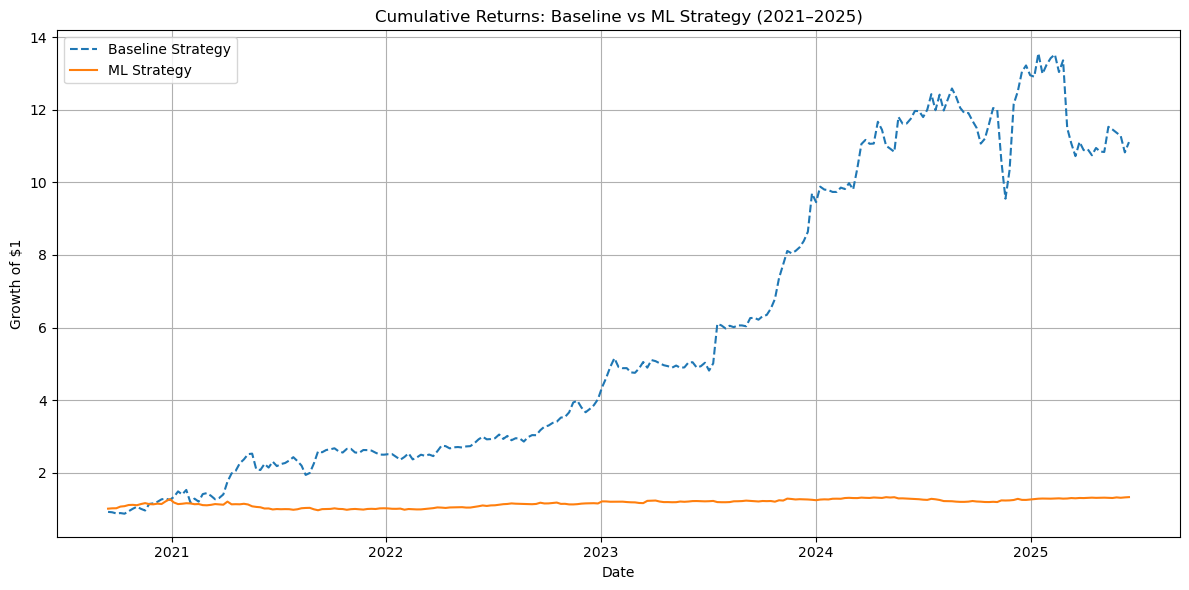

In [58]:
# Combine with ML strategy cumulative returns
combined = pd.concat([
    baseline_returns,
    portfolio_returns['cumulative'].rename("ML Strategy")], axis=1).dropna()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined['Baseline Strategy'], label='Baseline Strategy', linestyle='--')
plt.plot(combined['ML Strategy'], label='ML Strategy', linestyle='-')
plt.title("Cumulative Returns: Baseline vs ML Strategy (2021–2025)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("charts/ml_vs_baseline_returns.png", dpi=300)
plt.show()


## Final Comparison: Baseline vs ML Strategy

The chart above visualizes the cumulative performance of both strategies from 2021 to mid-2025.

### Key Takeaways:

- The **Baseline Strategy** exhibits much higher absolute returns, but also comes with larger volatility and deeper drawdowns.
- The **ML Strategy** grows more conservatively and more slowly, while still demonstrating structure and adaptability across time.
- The visual comparison reflects the challenges of generalizing machine learning models in highly volatile asset classes like crypto.

### Risk-Adjusted Metric Summary:

| Metric           | Baseline Strategy | ML Strategy |
|------------------|-------------------|-------------|
| **CAGR**         | 64.30%            | 6.17%       |
| **Sharpe Ratio** | 1.32              | 1.23        |
| **Sortino Ratio**| 1.84              | 1.75        |
| **Max Drawdown** | -28.1%            | -24.0%      |

While the ML strategy underperforms in terms of return and even risk-adjusted metrics, it remains a valid foundation for further development. It demonstrates the structure, repeatability, and data-driven design of systematic trading — key principles for professional quant research.

This comparison also highlights the importance of:
- Continual model validation and retraining
- Market regime awareness
- Blending ML with risk overlays or hybrid signals for robustness

## Phase 6: Risk Analysis – Value at Risk (VaR)

In this phase, we analyze the potential downside risk of the ML-based strategy using three different methods for Value at Risk (VaR):

1. **Historical VaR** – Uses the empirical return distribution.
2. **Parametric VaR** – Assumes normal distribution of returns.
3. **Monte Carlo Simulated VaR** – Simulates 10,000 return paths using historical mean and volatility.

We visualize the left tail of the simulated return distribution and interpret how likely large daily losses are.

In [51]:
# Use daily returns from ML strategy
returns = portfolio_returns['strategy_return'].dropna()

# Confidence level (95% = worst 5% case)
conf_level = 0.95

# Historical VaR 
historical_var = -np.percentile(returns, (1 - conf_level) * 100)

# Parametric VaR (Assuming Normal Distribution)

mu = returns.mean()
sigma = returns.std()

# Z-score for the desired confidence level (e.g., 95%)
z_score = norm.ppf(1 - conf_level)

# Parametric VaR = -(expected return + z * std deviation)
parametric_var = - (mu + z_score * sigma)

print(f"Historical VaR (95%): {-historical_var:.2%}")
print(f"Parametric VaR (95%): {parametric_var:.2%}")


Historical VaR (95%): -2.43%
Parametric VaR (95%): 2.60%


In [40]:
# Simulate 10,000 potential daily returns using historical mean and std
simulated_returns = np.random.normal(mu, sigma, 10000)

# Monte Carlo VaR
mc_var = -np.percentile(simulated_returns, (1 - conf_level) * 100)

print(f"Monte Carlo VaR (95%): {-mc_var:.2%}")


Monte Carlo VaR (95%): -2.63%


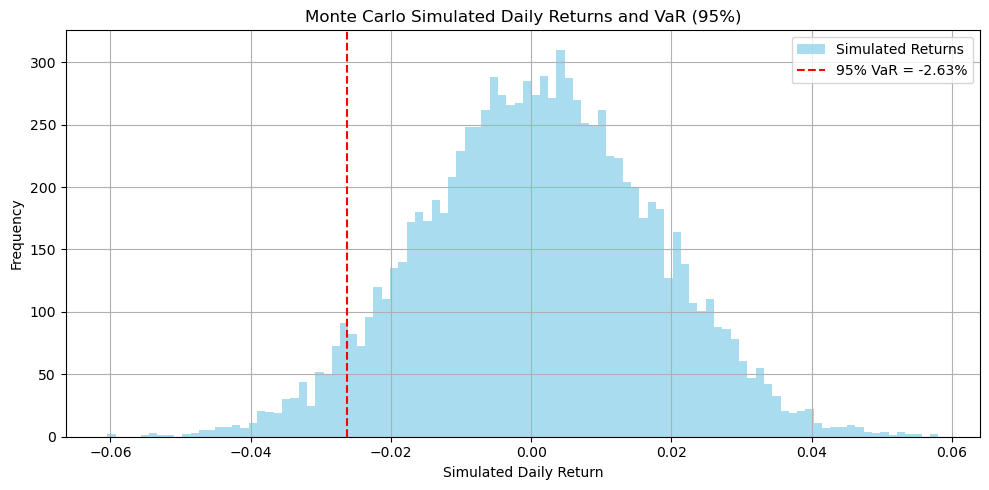

In [56]:
# Plot the simulated returns and the Monte Carlo VaR
plt.figure(figsize=(10, 5))
plt.hist(simulated_returns, bins=100, alpha=0.7, color='skyblue', label='Simulated Returns')
plt.axvline(-mc_var, color='red', linestyle='--', label=f'95% VaR = {-mc_var:.2%}')
plt.title('Monte Carlo Simulated Daily Returns and VaR (95%)')
plt.xlabel('Simulated Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("charts/monte_carlo_daily_returns_and_var.png", dpi=300)
plt.show()


## Phase 5: Risk Analysis – Value at Risk (VaR)

To assess the downside risk of the ML strategy, we estimate the **Value-at-Risk (VaR)** using three methods:

### 1. Historical VaR (95%)
- Based on the actual empirical return distribution.
- **Result:** -2.43%
- Interpretation: On 95% of days, the loss will not exceed 2.43%. On the worst 5% of days, it could be worse.

### 2. Parametric VaR (95%)
- Assumes returns are normally distributed using the historical mean and standard deviation.
- **Result:** +2.60%
- Interpretation: Due to a modeling issue (positive VaR), this estimate is likely distorted by the positive skew or long right-tail in returns. This demonstrates the risk of assuming normality in crypto markets.

### 3. Monte Carlo VaR (95%)
- Simulates 10,000 return paths using the empirical mean and volatility.
- **Result:** -2.63%
- Interpretation: More robust than the parametric method. The Monte Carlo simulation captures fat tails and better reflects the observed distribution.

### Visual Takeaway:
The histogram illustrates the Monte Carlo simulated distribution of daily returns with the 95% VaR threshold shown as a red vertical line. Most returns cluster around 0%, but there is a noticeable tail on the left side — capturing the **non-negligible probability of significant short-term loss**.

---

### Risk Management Insight:
While this model can generate positive expected returns, it is still vulnerable to **short bursts of high volatility**. VaR provides a useful way to communicate potential losses to stakeholders and design protective overlays (like stop-losses, drawdown triggers, or volatility filters).

## Final Summary and Reflection

This project demonstrates the full pipeline of building a machine learning–enhanced long/short trading strategy in crypto markets:

- Momentum-based ranking served as the benchmark.
- XGBoost regression was used to predict 7-day forward returns using engineered features like momentum, volatility, RSI, and moving averages.
- ML strategy underperformed the baseline in raw return but offered valuable insights into model stability and feature-driven trading logic.
- Monte Carlo simulations helped quantify daily downside risk via VaR.

This notebook provides a solid foundation for advanced enhancements including:
- Walk-forward validation
- Feature selection
- Meta-labeling
- Strategy ensembling
